In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, MaxPooling1D, concatenate,
    AveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [7]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [8]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [9]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [10]:
def inception_block(input_tensor, filters):
    conv1 = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(input_tensor)
    conv3 = Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu')(input_tensor)
    conv5 = Conv1D(filters=filters, kernel_size=5, padding='same', activation='relu')(input_tensor)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    pool_conv = Conv1D(filters=filters, kernel_size=1, padding='same', activation='relu')(pool)
    out = concatenate([conv1, conv3, conv5, pool_conv], axis=2)
    return out

In [11]:
inputs = Input(shape=(n_timesteps, n_features))
x = inception_block(inputs, 32)
x = inception_block(x, 64)
x = MaxPooling1D(pool_size=2)(x)
x = inception_block(x, 128)
x = MaxPooling1D(pool_size=2)(x)
flat = Flatten()(x)
dense = Dense(512, activation='relu')(flat)
outputs = Dense(n_outputs, activation='softmax')(dense)

cnn_inception_model = Model(inputs, outputs)
cnn_inception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_inception_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 128, 9)    │          0 │ input_layer[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 32)   │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 32)   │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 32)   │      1,472 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 32)   │        320 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 128, 128)  │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 64)   │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 64)   │     41,024 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 64)   │      8,256 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 256)  │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 64, 256)   │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 64, 256)   │          0 │ max_pooling1d_2[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 64, 128)   │     32,896 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 64, 128)   │     98,432 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 64, 128)   │    163,968 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 64, 128)   │     32,896 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 8,805,574 (33.59 MB)

 Trainable params: 8,805,574 (33.59 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model_history = cnn_inception_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 67s 372ms/step - accuracy: 0.7306 - loss: 0.9291 - val_accuracy: 0.9457 - val_loss: 0.1251
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 60s 360ms/step - accuracy: 0.9482 - loss: 0.1313 - val_accuracy: 0.9508 - val_loss: 0.1017
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 60s 360ms/step - accuracy: 0.9587 - loss: 0.1115 - val_accuracy: 0.9525 - val_loss: 0.1104
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 80s 350ms/step - accuracy: 0.9592 - loss: 0.1082 - val_accuracy: 0.9338 - val_loss: 0.1511
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 348ms/step - accuracy: 0.9534 - loss: 0.1103 - val_accuracy: 0.9593 - val_loss: 0.1033
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 82s 347ms/step - accuracy: 0.9516 - loss: 0.1377 - val_accuracy: 0.9457 - val_loss: 0.1258
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 58s 348ms/step - accuracy: 0.9538 - loss: 0.1040 - val_accuracy: 0.9542 - val_loss: 0.1059
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 59s 353ms/step - accuracy: 0.9592 - loss: 0

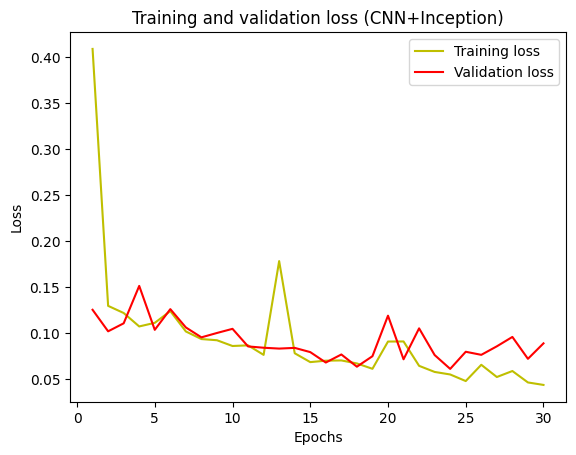

In [13]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (CNN+Inception)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

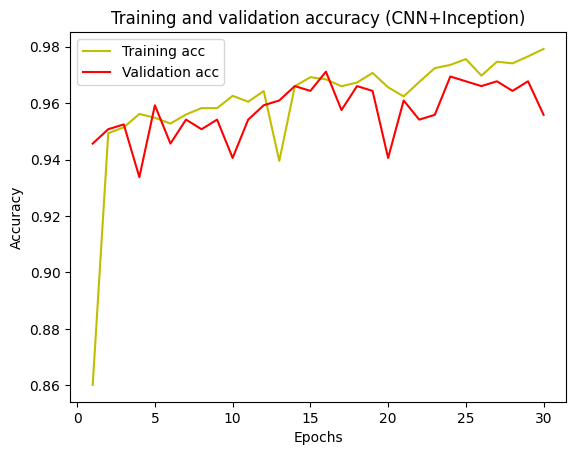

In [14]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (CNN+Inception)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step
[[484   5   4   1   2   0]
 [ 11 439  18   3   0   0]
 [  3   9 408   0   0   0]
 [  0   2   0 409  74   6]
 [  0   0   0  84 448   0]
 [  0   0   0   0   0 537]]
0.9246691550729556
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       496
           1       0.96      0.93      0.95       471
           2       0.95      0.97      0.96       420
           3       0.82      0.83      0.83       491
           4       0.85      0.84      0.85       532
           5       0.99      1.00      0.99       537

    accuracy                           0.92      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

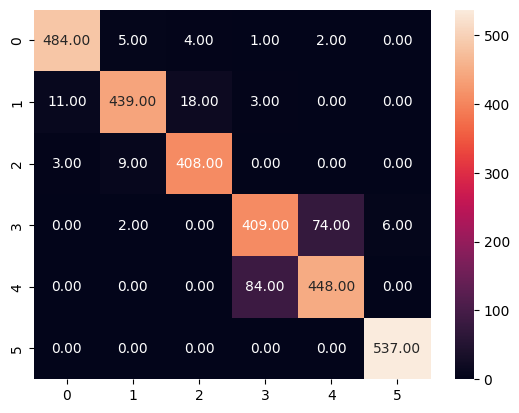

In [15]:
pred = cnn_inception_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')